In [1]:
%config Completer.use_jedi=False
%config InlineBackend.figure_format = 'retina'

# import the necessary libraries

import torch
import torch.nn as nn

from torchvision.transforms import Grayscale, ToTensor, RandomRotation
from torchvision.transforms import RandomAffine, Resize

from torch.optim import SGD
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision import datasets

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd

import json
import session_info

In [2]:
session_info.show()

In [2]:
# configure the device to use for training the model, either gpu or cpu

# device = "cuda" if torch.cuda.is_available() else "cpu"

device = "cpu"
print(f"[INFO] Current training device: {device}")

[INFO] Current training device: cpu


In [4]:
# initialize a list of preprocessing steps to apply on each image during
# training/validation and testing
train_transform = transforms.Compose([
    Grayscale(num_output_channels=1), 
    Resize((32,32)),
    ToTensor(),
])

test_transform = transforms.Compose([
    Grayscale(num_output_channels=1),
    Resize((32,32)),
    ToTensor()
])

In [5]:
trainDirectory = 'my_train/'
testDirectory = 'my_test/'

In [6]:
# load all the images within the specified folder and apply different augmentation
train_data = datasets.ImageFolder(trainDirectory, transform=train_transform)
test_data = datasets.ImageFolder(testDirectory, transform=test_transform)

In [7]:
train_data

Dataset ImageFolder
    Number of datapoints: 44291
    Root location: my_train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [8]:
train_data.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [9]:
train_data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
# extract the class labels and the total number of classes
classes = train_data.classes
num_of_classes = len(classes)
print(f"[INFO] Class labels: {classes}")

[INFO] Class labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):        
        super(NeuralNetwork, self).__init__()
        
        # Convolutional Neural Network Layer 
        self.convolutional = nn.Sequential(
            
            # in_channels = 1 grayscale image   
            # input (N, 1, 32, 32)
            # conv output = [(input size + 2*padding - kernel_size) / stride] + 1            

            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1), 
            # first conv layer output >>> [(32 + 2 - 3) / 1] + 1 = 32

            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),            
            # second conv layer output >>> [(32 + 2 - 3) / 1] + 1 = 32

            nn.ReLU(),          
            nn.MaxPool2d(kernel_size=2), # maxpooling output >>> 32 / 2 = 16
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            # third conv layer output >>> [(16 + 2 - 3) / 1] + 1 = 16

            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            # fourth conv layer output >>> [(16 + 2 - 3) / 1] + 1 = 16

            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2),  # maxpooling output >>> 16 / 2 = 8        
            nn.Dropout(p=0.3),


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),          
            # fift conv layer output >>> [(8 + 2 - 3) / 1] + 1 = 8

            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            # sixth conv layer output = [(8 + 2 - 3) / 1] + 1 = 8

            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2),  # maxpooling output >>> 8/ 2 = 4        
            nn.Dropout(p=0.3), 
        )
        
        # Linear layer
        self.classifier = nn.Sequential(                
                # output_channel of last conv layer * img_height * img_width after maxpooling
                nn.Linear(in_features=128*4*4, out_features=128),          
                nn.ReLU(),
                nn.Dropout(p=0.4),
                nn.Linear(in_features=128, out_features=10) # out_features = number of classes
        )
        
    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutional(x)
        # output of conv layer must be flatten or rearranged into a vector
        x = x.view(x.size(0), -1)
        # output is passed through the linear layer
        x = self.classifier(x)
        return x

In [12]:
# configuration
NUM_OF_EPOCHS = 70
BATCH_SIZE = 32
LR= 0.001

In [13]:
# load our own dataset and store each sample with their corresponding labels
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

Loaded image batch shape: torch.Size([32, 1, 32, 32])
Loaded label shape: torch.Size([32])
Single image shape: torch.Size([32, 32])


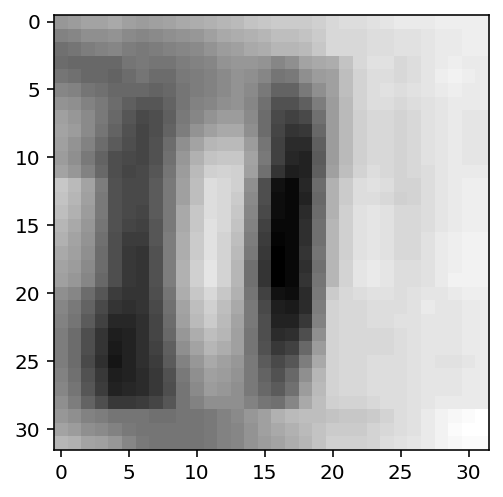

Label: 0


In [14]:
# Display image and label.
loaded_img, loaded_label = next(iter(train_dataloader))

print(f"Loaded image batch shape: {loaded_img.size()}")
print(f"Loaded label shape: {loaded_label.size()}")

img = loaded_img[4].squeeze()
# img = img.permute(1, 2, 0)

print(f"Single image shape: {img.size()}")

label = loaded_label[4]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

In [15]:
# initialize the model 
model = NeuralNetwork()

In [16]:
# send the model to device
model = model.to(device)

In [18]:
model

NeuralNetwork(
  (convolutional): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [19]:
# initialize our optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [20]:
data, target = next(iter(train_dataloader))

model.train()

total = 0
# training our model
for i in range(10):

    # Compute prediction and loss
    pred = model(data)
    loss = criterion(pred, target)
    
    print(loss.item())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

2.141407012939453
0.5069459080696106
0.012386782094836235
9.845048771239817e-05
3.855586328427307e-06
3.688021763537108e-07
0.0
0.0
0.0
0.0


In [21]:
# calculate the steps per epoch for training and test set
train_steps = len(train_dataloader.dataset) // BATCH_SIZE
test_steps = len(test_dataloader.dataset) // BATCH_SIZE

In [22]:
# initialize a dictionary to save the training history
history = {
    "train_acc": [],
    "train_loss": [],
    "test_acc": [],
    "test_loss": []
}

In [23]:
# iterate through the epochs
print(f"[INFO] Training the model...")

for epoch in range(0, NUM_OF_EPOCHS):
 
    """
    Training the model
    """
    # set the model to training mode
    model.train()
 
    # initialize the total training and validation loss and
    # the total number of correct predictions in both steps
    total_train_loss = 0
    total_test_loss = 0
    train_correct = 0
    test_correct = 0
 
    # iterate through the training set
    for (data, target) in train_dataloader:
        # move the data into the device used for training,
        data, target = data.to(device), target.to(device)
 
        # perform a forward pass and calculate the training loss
        predictions = model(data)
        loss = criterion(predictions, target)
 
        # zero the gradients accumulated from the previous operation,
        # perform a backward pass, and then update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        # add the training loss and keep track of the number of correct predictions
        total_train_loss += loss
        train_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()
        
    """
    Validating the model
    """
    model.eval()  # disable dropout and dropout layers
 
    # prevents pytorch from calculating the gradients, reducing
    # memory usage and speeding up the computation time (no back prop)
    with torch.set_grad_enabled(False):
 
        # iterate through the validation set
        for (data, target) in test_dataloader:
            # move the data into the device used for testing
            data, target = data.to(device), target.to(device)
 
            # perform a forward pass and calculate the training loss
            predictions = model(data)
            loss = criterion(predictions, target)
 
            # add the training loss and keep track of the number of correct predictions
            total_test_loss += loss
            test_correct += (predictions.argmax(1) == target).type(torch.float).sum().item()
        
    # calculate the average training and validation loss
    avg_train_loss = total_train_loss / train_steps
    avg_test_loss = total_test_loss / test_steps
 
    # calculate the train and validation accuracy
    train_correct = train_correct / len(train_dataloader.dataset)
    test_correct = test_correct / len(test_dataloader.dataset)
 
    print(f"[INFO] epoch: {epoch+1}/{NUM_OF_EPOCHS}",
      f"train loss: {avg_train_loss:.3f}",
      f"test loss: {avg_test_loss:.3f}",
      f"train accuracy: {train_correct:.3f}",
      f"test accuracy: {test_correct:.3f}")
    

    # update the training and validation results
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    history['train_acc'].append(train_correct)
    history['test_loss'].append(avg_test_loss.cpu().detach().numpy())
    history['test_acc'].append(test_correct)
            

[INFO] Training the model...
[INFO] epoch: 1/30 train loss: 2.023 test loss: 2.306 train accuracy: 0.493 test accuracy: 0.092
[INFO] epoch: 2/30 train loss: 2.303 test loss: 2.271 train accuracy: 0.133 test accuracy: 0.195
[INFO] epoch: 3/30 train loss: 2.280 test loss: 2.257 train accuracy: 0.186 test accuracy: 0.195
[INFO] epoch: 4/30 train loss: 2.778 test loss: 89.629 train accuracy: 0.486 test accuracy: 0.061
[INFO] epoch: 5/30 train loss: 1.391 test loss: 25.678 train accuracy: 0.832 test accuracy: 0.061
[INFO] epoch: 6/30 train loss: 0.842 test loss: 11.471 train accuracy: 0.873 test accuracy: 0.061
[INFO] epoch: 7/30 train loss: 1.091 test loss: 11.533 train accuracy: 0.607 test accuracy: 0.061
[INFO] epoch: 8/30 train loss: 1.202 test loss: 8.223 train accuracy: 0.672 test accuracy: 0.061
[INFO] epoch: 9/30 train loss: 1.925 test loss: 2.326 train accuracy: 0.367 test accuracy: 0.091
[INFO] epoch: 10/30 train loss: 2.284 test loss: 2.244 train accuracy: 0.186 test accuracy: 0.

In [24]:
# save torch model
PATH= f'models/my_model_e{NUM_OF_EPOCHS}_b{BATCH_SIZE}_lr{LR}.pth'
torch.save(model.state_dict(), PATH)

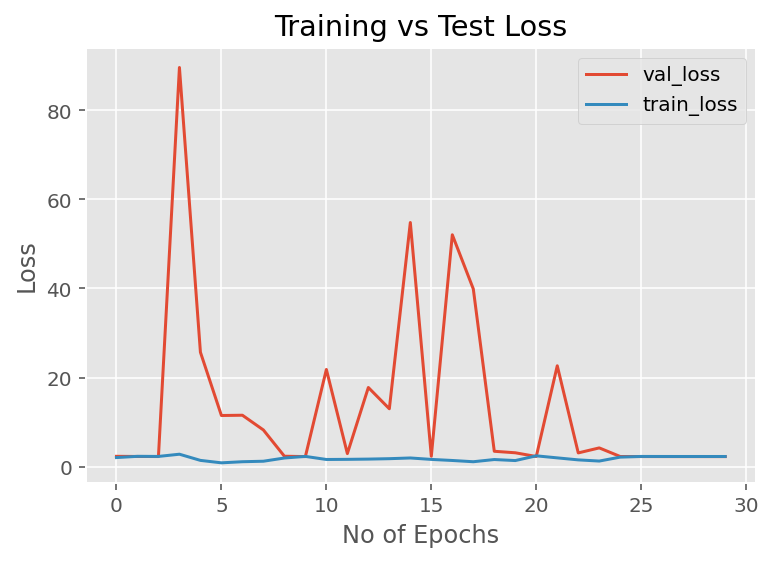

In [25]:
# plot the training loss and accuracy overtime
plt.style.use("ggplot")
plt.figure()
plt.plot(history['test_loss'], label='val_loss')
plt.plot(history['train_loss'], label='train_loss')
plt.ylabel('Loss')
plt.xlabel("No of Epochs")
plt.title('Training vs Test Loss')
plt.legend(loc='upper right')

In [26]:
# clear the plots and set to default not to mess confusion matrix plot
plt.clf()
plt.close('all')
plt.style.use('default')

In [27]:
# store actual values
actual = test_dataloader.dataset.targets

In [28]:
# get predictions
with torch.set_grad_enabled(False):
    # set the evaluation mode
    model.eval()
 
    # initialize a list to keep track of our predictions
    predictions = []
 
    # iterate through the test set
    for (data, _) in test_dataloader:
        # move the data into the device used for testing
        data = data.to(device)
 
        # perform a forward pass and calculate the training loss
        output = model(data)
        output = output.argmax(axis=1).cpu().numpy()
        # store predicted values
        predictions.extend(output)

In [29]:
# print the classification report

In [31]:
print(classification_report(actual, predictions, target_names=test_data.classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1236
           1       0.19      1.00      0.33      3629
           2       0.00      0.00      0.00      2960
           3       0.00      0.00      0.00      2122
           4       0.00      0.00      0.00      1700
           5       0.00      0.00      0.00      1717
           6       0.00      0.00      0.00      1460
           7       0.00      0.00      0.00      1431
           8       0.00      0.00      0.00      1224
           9       0.00      0.00      0.00      1137

    accuracy                           0.19     18616
   macro avg       0.02      0.10      0.03     18616
weighted avg       0.04      0.19      0.06     18616



/home/igi/jupyter_notebooks/jupyter_venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/igi/jupyter_notebooks/jupyter_venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/igi/jupyter_notebooks/jupyter_venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [32]:
# display confusion matrix

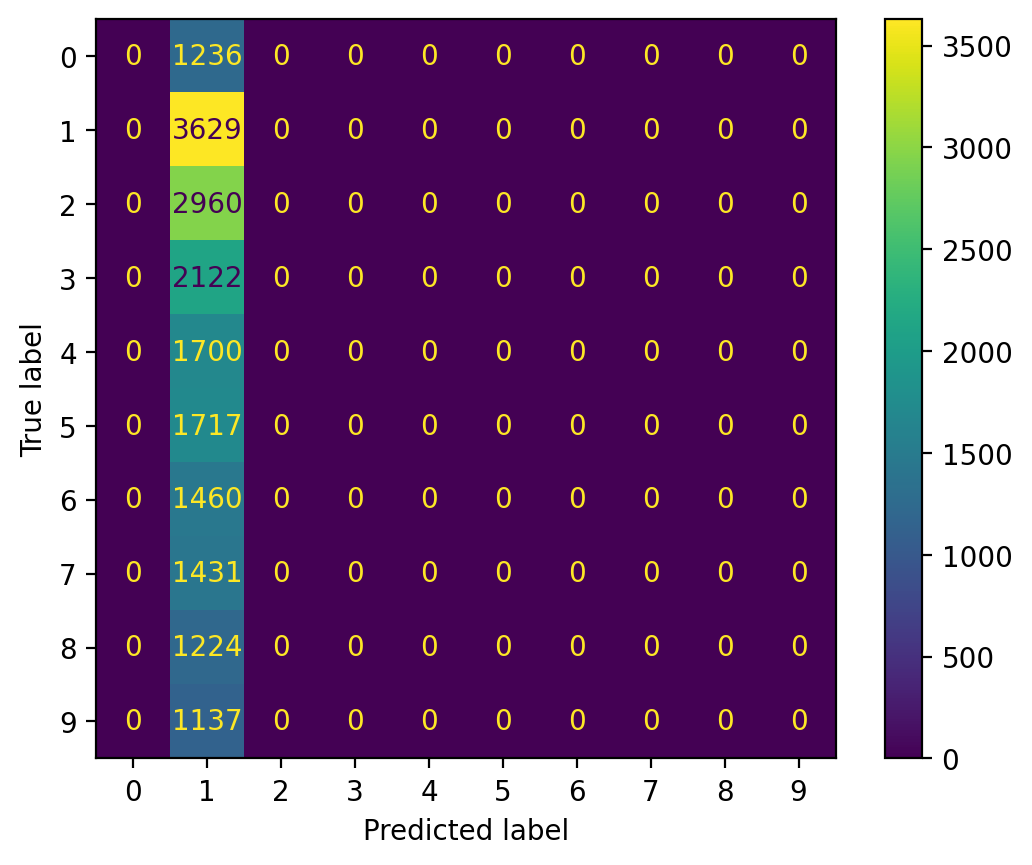

In [33]:
cm = confusion_matrix(actual, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
disp.plot()
plt.show()